In [1]:
# Install dependencies (g++ >7.0, CMake 3.15.5+)
!apt-get update
!apt-get install -y g++-11 cmake
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-11 100
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-11 100

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,809 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,111 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,103 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,266 kB]
Hit:13 https://ppa.launc

In [2]:
# Clone and checkout cuda11 branch (for CUDA 11.0+)
!git clone https://github.com/GPUPeople/spECK.git
%cd spECK
!git checkout cuda11 --force

Cloning into 'spECK'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (313/313), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 313 (delta 137), reused 267 (delta 103), pack-reused 0 (from 0)
Receiving objects: 100% (313/313), 386.60 KiB | 3.72 MiB/s, done.
Resolving deltas: 100% (137/137), done.
/content/spECK
Branch 'cuda11' set up to track remote branch 'cuda11' from 'origin'.
Switched to a new branch 'cuda11'


# Set spECK_STATIC_MEM_PER_BLOCK and spECK_DYNAMIC_MEM_PER_BLOCK in include/Multiply.h line 9 & 10 to the values your hardware supports
spECK_STATIC_MEM_PER_BLOCK should be 49152 for all recent devices

spECK_DYNAMIC_MEM_PER_BLOCK = 101376 for Ampere devices

In [3]:
%cd /content/spECK
!rm -rf build
!mkdir build
%cd build
!cmake -DCMAKE_CUDA_ARCHITECTURES=80 ..
!make -j$(nproc)

/content/spECK
/content/spECK/build
-- The CXX compiler identification is GNU 11.4.0
-- The CUDA compiler identification is NVIDIA 12.5.82 with host compiler GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Build type not specified: Use Release by default
-- Configuring done (3.8s)
-- Generating done (0.0s)
-- Build files have been written to: /content/spECK/build
[  6%] Building CUDA object CMakeFiles/spECKLib.dir/source/GPU/Transpose.cu.o
[ 20%] Building CXX object CMakeFiles/spECKLib.dir/source/GPU/memory.cpp.o
[ 20%] Building CUDA object CMakeFiles/spECKLib.dir/source/GPU/Compare.cu.o
[ 

In [7]:
# Mount Google Drive
from google.colab import drive
import os
import subprocess
import glob

# Mount drive
drive.mount('/content/drive')

# Navigate to spECK directory (assuming it's already built)
os.chdir('/content/spECK')

# Define paths
MATRICES_PATH = '/content/drive/MyDrive/SparseMatrices'
SPECK_EXECUTABLE = './build/runspECK'
CONFIG_FILE = 'config.ini'

# Check if spECK executable exists
if not os.path.exists(SPECK_EXECUTABLE):
    print("Error: spECK executable not found. Make sure to build spECK first.")
    print("Current directory:", os.getcwd())
    print("Files in build directory:", os.listdir('./build') if os.path.exists('./build') else "build directory not found")

# Check if matrices directory exists
if not os.path.exists(MATRICES_PATH):
    print(f"Error: Matrices directory not found at {MATRICES_PATH}")
    print("Available directories in Google Drive:")
    print(os.listdir('/content/drive/MyDrive'))
else:
    print(f"Found matrices directory: {MATRICES_PATH}")
    print("Available matrix folders:")
    matrix_folders = [f for f in os.listdir(MATRICES_PATH) if os.path.isdir(os.path.join(MATRICES_PATH, f))]
    for folder in matrix_folders:
        print(f"  - {folder}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found matrices directory: /content/drive/MyDrive/SparseMatrices
Available matrix folders:
  - pdb1HYS
  - mc2depi
  - webbase-1M
  - mac_econ_fwd500
  - consph
  - cop20k_A
  - scircuit
  - conf5_4-8x8-05
  - rma10
  - shipsec1
  - pwtk
  - cant


In [8]:
# Create or modify config.ini for benchmarking
config_content = """
TrackCompleteTimes=true
TrackIndividualTimes=true
CompareResult=false
IterationsWarmUp=3
IterationsExecution=5
"""

with open(CONFIG_FILE, 'w') as f:
    f.write(config_content.strip())

print(f"Created config file: {CONFIG_FILE}")

# Function to run spECK on a single matrix
def run_speck_on_matrix(matrix_path, matrix_name):
    """Run spECK on a single matrix file"""

    try:
        # Run spECK with the matrix file
        cmd = [SPECK_EXECUTABLE, matrix_path, CONFIG_FILE]
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)  # 5 minute timeout

        print("STDOUT:")
        print(result.stdout)

        if result.stderr:
            print("STDERR:")
            print(result.stderr)

        if result.returncode != 0:
            print(f"Error: spECK exited with code {result.returncode}")

    except subprocess.TimeoutExpired:
        print(f"Timeout: Matrix {matrix_name} took too long to process")
    except Exception as e:
        print(f"Error running spECK on {matrix_name}: {e}")

# Function to find matrix files in each folder
def find_matrix_files(matrices_path):
    """Find all .mtx files in the matrices directory"""
    matrix_files = []

    for folder in os.listdir(matrices_path):
        folder_path = os.path.join(matrices_path, folder)
        if os.path.isdir(folder_path):
            # Look for .mtx files in each folder
            mtx_files = glob.glob(os.path.join(folder_path, "*.mtx"))
            for mtx_file in mtx_files:
                matrix_files.append((mtx_file, folder))

    return matrix_files

# Main execution
if os.path.exists(SPECK_EXECUTABLE) and os.path.exists(MATRICES_PATH):

    # Find all matrix files
    matrix_files = find_matrix_files(MATRICES_PATH)

    if not matrix_files:
        print("No .mtx files found in the matrices directory")
        print("Checking directory structure...")
        for folder in os.listdir(MATRICES_PATH)[:5]:  # Show first 5 folders
            folder_path = os.path.join(MATRICES_PATH, folder)
            if os.path.isdir(folder_path):
                files = os.listdir(folder_path)
                print(f"  {folder}/: {files}")
    else:
        print(f"Found {len(matrix_files)} matrix files to test")

        # Test each matrix
        for matrix_path, matrix_name in matrix_files:
            run_speck_on_matrix(matrix_path, matrix_name)


# Additional utility: Test a single matrix by name
def test_single_matrix(matrix_name):
    """Test a single matrix by folder name"""
    matrix_path = os.path.join(MATRICES_PATH, matrix_name)
    if os.path.exists(matrix_path):
        mtx_files = glob.glob(os.path.join(matrix_path, "*.mtx"))
        if mtx_files:
            run_speck_on_matrix(mtx_files[0], matrix_name)
        else:
            print(f"No .mtx file found in {matrix_path}")
    else:
        print(f"Matrix folder {matrix_name} not found")


Created config file: config.ini
Found 12 matrix files to test
STDOUT:
trying to load csr file "/content/drive/MyDrive/SparseMatrices/pdb1HYS/pdb1HYS.mtxd_.hicsr"
successfully loaded: "/content/drive/MyDrive/SparseMatrices/pdb1HYS/pdb1HYS.mtxd_.hicsr"
Matrix: 36417x36417: 4344765 nonzeros
spECK     initial mallocs = 4.830208 ms
spECK  count computations = 0.281600 ms
spECK       load-balancer = 0.130048 ms
spECK      GlobalMaps Cnt = 0.009216 ms
spECK     counting kernel = 6.109184 ms
spECK        malloc mat C = 0.274432 ms
spECK   num load-balancer = 0.146432 ms
spECK     init GlobalMaps = 0.010240 ms
spECK      numeric kernel = 10.116096 ms
spECK      Sorting kernel = 1.101824 ms
spECK             cleanup = 0.022528 ms
--------------------------------------------------------------
spECK            complete = 23.181313 ms

spECK     initial mallocs = 0.028672 ms
spECK  count computations = 0.254976 ms
spECK       load-balancer = 0.093184 ms
spECK      GlobalMaps Cnt = 0.009216 ms
spECK

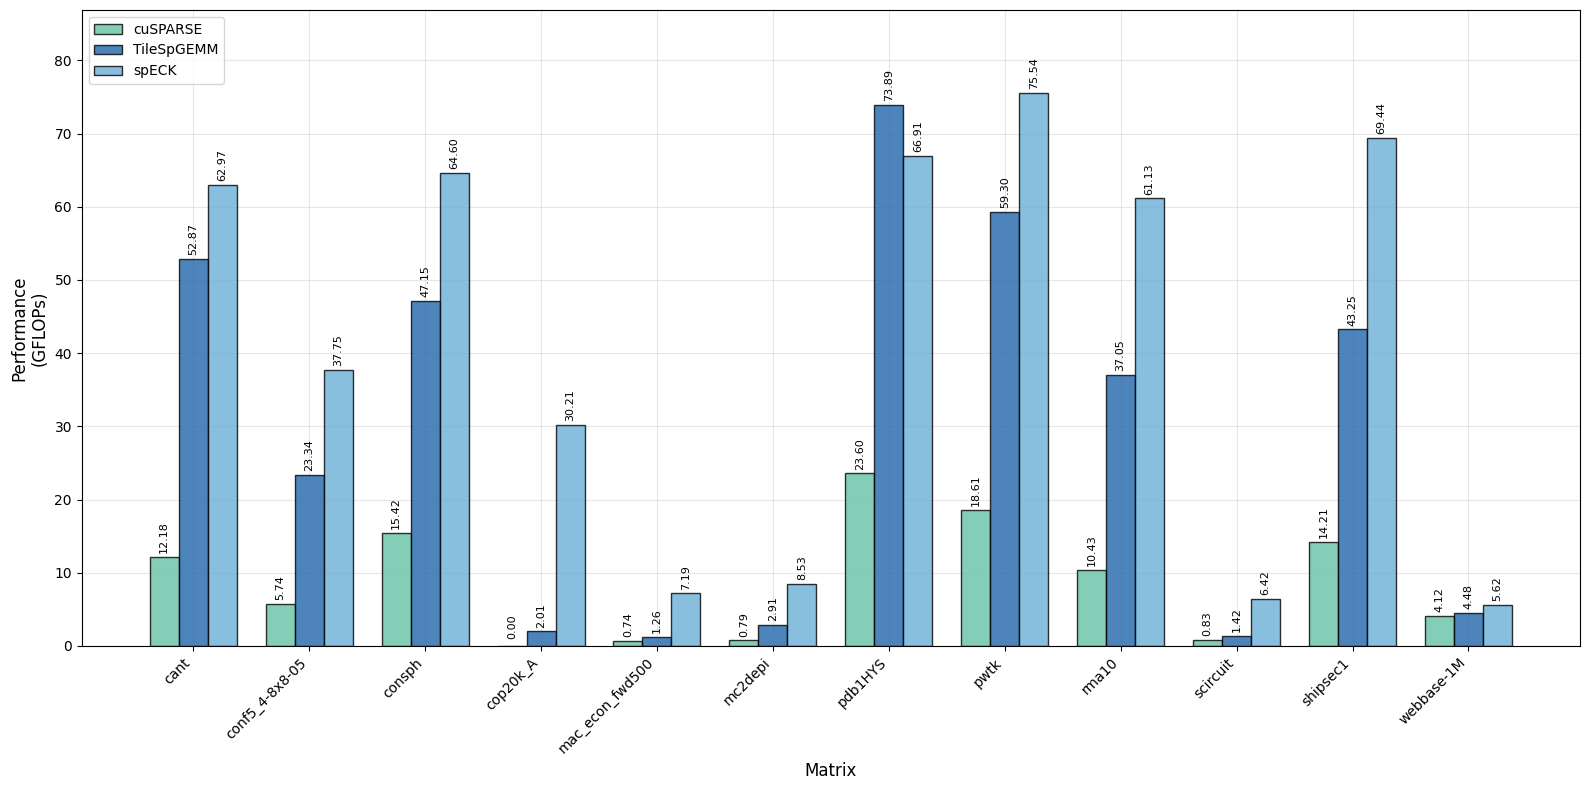

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Performance data in GFLOPs
matrices = ['cant', 'conf5_4-8x8-05', 'consph', 'cop20k_A', 'mac_econ_fwd500',
           'mc2depi', 'pdb1HYS', 'pwtk', 'rma10', 'scircuit',
           'shipsec1', 'webbase-1M']

cusparse_gflops = [12.18, 5.74, 15.42, 0, 0.74, 0.79, 23.60, 18.61, 10.43, 0.83, 14.21, 4.12]
tilespgemm_gflops = [52.87, 23.34, 47.15, 2.01, 1.26, 2.91, 73.89, 59.30, 37.05, 1.42, 43.25, 4.48]
speck_gflops = [62.97, 37.75, 64.60, 30.21, 7.19, 8.53, 66.91, 75.54, 61.13, 6.42, 69.44, 5.62]

fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.25
x_pos = np.arange(len(matrices))

# Create bars
bars1 = ax.bar(x_pos - bar_width, cusparse_gflops, bar_width,
               label='cuSPARSE', color='#66c2a5', alpha=0.8,
               edgecolor='black', linewidth=1)
bars2 = ax.bar(x_pos, tilespgemm_gflops, bar_width,
               label='TileSpGEMM', color='#2166ac', alpha=0.8,
               edgecolor='black', linewidth=1)
bars3 = ax.bar(x_pos + bar_width, speck_gflops, bar_width,
               label='spECK', color='#6baed6', alpha=0.8,
               edgecolor='black', linewidth=1)

# Add value labels on top of bars
def add_value_labels(bars, values):
    for i, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        if value == 0:
            ax.text(bar.get_x() + bar.get_width()/2., 1.0,
                   '0.00',
                   ha='center', va='bottom', fontsize=8, rotation=90)
        elif height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{value:.2f}',
                   ha='center', va='bottom', fontsize=8, rotation=90)

add_value_labels(bars1, cusparse_gflops)
add_value_labels(bars2, tilespgemm_gflops)
add_value_labels(bars3, speck_gflops)

ax.set_xlabel('Matrix', fontsize=12)
ax.set_ylabel('Performance\n(GFLOPs)', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(matrices, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, which='both')
ax.set_axisbelow(True)
ax.set_ylim(0, max(max(cusparse_gflops), max(tilespgemm_gflops), max(speck_gflops)) * 1.15)

plt.tight_layout()
plt.show()